In [196]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## Define matrices

In [197]:
def create_spin_chain_mps(N: int, chi: int, seed: int, min_val: float, max_val: float, dtype=jnp.float32):
    '''Creates list of tensors that define the MPS of a quantum spin 1/2 chain
    The first and last tensors will have two indices, the rest have 3
    The first index has dimension 2, and the rest have bond dimension equal to chi
    '''
    
    # Create random keys
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, N)
    
    # Scale factor for uniform distribution
    scale_factor = max_val - min_val
    
    # Initialize tensor list
    mps = []
    
    # First tensor
    mps.append(min_val + scale_factor * jax.random.uniform(keys[0], (2, chi), dtype=dtype))
    
    # Middle tensors
    for i in range(1, N-1):
        mps.append(min_val + scale_factor * jax.random.uniform(keys[i], (2, chi, chi), dtype=dtype))
    
    # Last tensor
    mps.append(min_val + scale_factor * jax.random.uniform(keys[N-1], (2, chi), dtype=dtype))
    
    return mps



In [202]:
def generate_bitstring_list(nqubits):
    bitstrings = []
    decimal_bitstrings = range(0, 2**nqubits)
    int_bitstrings = [bin(i)[2:].zfill(nqubits) for i in decimal_bitstrings]
    bitstrings =  [str(bit) for bit in int_bitstrings]

    return bitstrings

def get_amplitude(mps, string):
    current = mps[0][int(string[0])]
    # Contract with middle tensors
    for i in range(1, N-1):
        tensor_slice = mps[i][int(string[i])]
        
        current = jnp.dot(current, tensor_slice)
    
    # Contract with last tensor
    last_slice = mps[-1][int(string[-1])]
    
    # Final contraction gives scalar
    amplitude = float(jnp.dot(current, last_slice))
    
    return amplitude

def extract_amplitudes(mps):
    num_qubits = len(mps)
    bitstrings = generate_bitstring_list(num_qubits)
    probs = []
    for string in bitstrings:
        amp = get_amplitude(mps, string)
        probs.append(amp**2)

    total_prob = sum(probs)
    normalized_probs = [p/total_prob for p in probs]
    return bitstrings, normalized_probs


def sample_from_bitstrings(nqubits, N_shots, probs, seed):
    dim = 2**nqubits
    counts_shots = []
    rng = np.random.default_rng(seed)
    samples = rng.choice(dim, size=N_shots, p=probs)
    hist = np.bincount(samples, minlength=dim)
    counts_shots.append(hist)

    return counts_shots


In [214]:
# Test
seed = 1234
N = 6
chi = 4
min_val = 0
max_val = 1

mps = create_spin_chain_mps(N, chi, seed, min_val, max_val)

# Check the shapes
print(f"Number of tensors: {len(mps)}")
for i, tensor in enumerate(mps):
    print(f"Tensor {i}: shape = {tensor.shape}, dtype = {tensor.dtype}")

bitstrings, probs = extract_amplitudes(mps)
print(probs)

Number of tensors: 6
Tensor 0: shape = (2, 4), dtype = float32
Tensor 1: shape = (2, 4, 4), dtype = float32
Tensor 2: shape = (2, 4, 4), dtype = float32
Tensor 3: shape = (2, 4, 4), dtype = float32
Tensor 4: shape = (2, 4, 4), dtype = float32
Tensor 5: shape = (2, 4), dtype = float32
[0.008985581396132647, 0.00869839838589178, 0.008499268818037706, 0.0068791649854822055, 0.006045446222518875, 0.005048166122362236, 0.005632900927949399, 0.004058873622121919, 0.013117037736308367, 0.013202039333152667, 0.013515596063115897, 0.012022587033288646, 0.00693311834140949, 0.006251859862789436, 0.0058901182565712406, 0.004151321296901965, 0.01611557223742949, 0.016101834559919016, 0.015701558289961098, 0.013224740161757407, 0.011218980642965521, 0.00954434757425749, 0.010660760692199378, 0.007910053215775825, 0.03268680410960928, 0.03227830138071429, 0.033034433294088, 0.02863429947171899, 0.01735519640147381, 0.015380104401465975, 0.014935094581451995, 0.01050919691300115, 0.00943227066163643,

In [215]:
def bar_plot_strings(strings, values, title="Bar Plot", xlabel="Categories", ylabel="Values", 
                     color='skyblue', edgecolor='black', figsize=(10, 6)):
    """
    Quick bar plot with string labels on x-axis.
    
    Parameters:
    -----------
    strings : list of str
        Labels for x-axis (bar categories)
    values : list of float/int
        Values for y-axis (bar heights)
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    color : str or list
        Bar color(s)
    edgecolor : str
        Bar edge color
    figsize : tuple
        Figure size (width, height)
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    x_pos = np.arange(len(strings))
    bars = ax.bar(x_pos, values, color=color, edgecolor=edgecolor, alpha=0.8)
    
    # Customize plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # Set x-ticks to string labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(strings, rotation=45, ha='right', fontsize=10)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax, bars

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Bitstring probabilities'}, xlabel='Categories', ylabel='Values'>,
 <BarContainer object of 64 artists>)

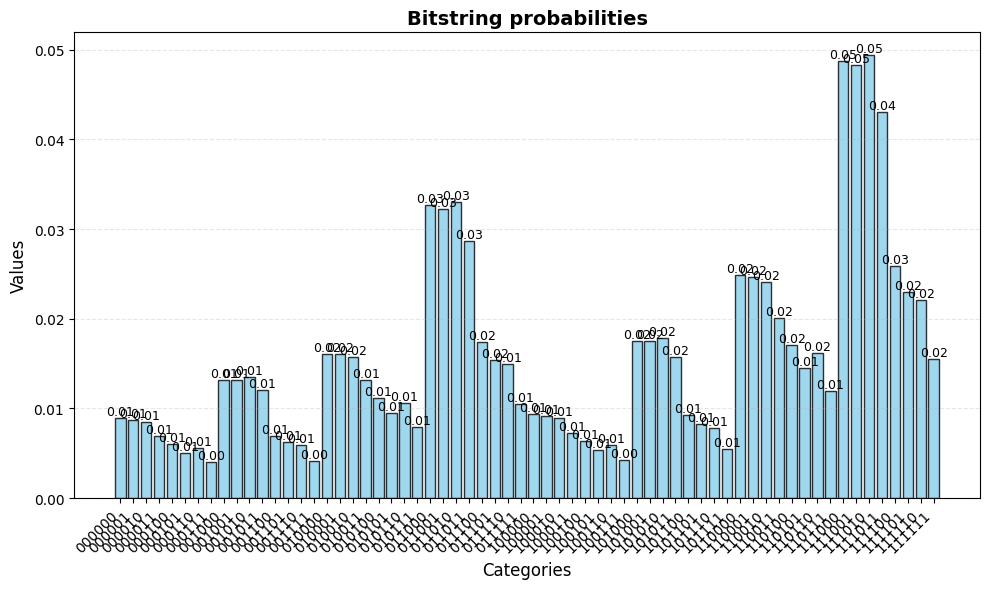

In [216]:
bar_plot_strings(bitstrings, probs, "Bitstring probabilities")

In [221]:
counts_shots = sample_from_bitstrings(N, 10000, probs, seed)

[array([102,  84,  93,  70,  62,  59,  58,  37, 122, 123, 130, 114,  71,
        52,  52,  49, 169, 170, 158, 112, 129,  90, 100,  65, 335, 314,
       323, 307, 190, 160, 146,  90,  88, 109,  77,  58,  63,  47,  59,
        43, 183, 169, 167, 170, 103,  83,  81,  58, 249, 260, 264, 186,
       181, 148, 168, 123, 513, 474, 468, 399, 243, 235, 238, 157])]


37
